# Практическая работа 2.1. Анализ данных с помощью DASK


**Задание.**

`2.1.1.` Настроить среду и рабочий каталог.

`2.1.2.` Загрузить данные.

`2.1.3.` Проверить качество данных (например, отсутствующие значения и выбросы).

`2.1.4.` Удалить столбцы (множество пропусков в значениях, бесполезные столбцы для анализа).

`2.1.1.` **Настроить среду и рабочий каталог.**

In [ ]:
%pip install "dask[complete]"

In [ ]:
# import libraries
import sys
import os

## import dask libraries
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# import libraries
import pandas as pd

In [3]:
cwd = os.getcwd()

# print
print('', sys.executable)
print('', cwd)

 c:\Users\Nastya\AppData\Local\Programs\Python\Python311\python.exe
 d:\МГПУ 4 курс\Проектный практикум по разработке ETL-решений\etl git\etl\ПР2


`2.1.2.` **Загрузить данные.**

In [4]:
## read data using DataFrame API
df = dd.read_csv('Parking_Violations_Issued_-_Fiscal_Year_2015.csv', dtype={'Meter Number': 'object',
       'Time First Observed': 'object', 
       'Double Parking Violation': 'object',
       'Hydrant Violation': 'object',
       'No Standing or Stopping Violation': 'object',
       'Violation Legal Code': 'object'}, assume_missing=True)
df

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
npartitions=44,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,string,string,string,string,float64,string,string,string,float64,float64,float64,string,float64,float64,float64,float64,string,string,string,string,string,string,string,string,string,string,float64,string,string,string,string,string,string,float64,float64,string,float64,string,string,string,string,string,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Обратите внимание, что

- `metadata` отображаются в кадре вместо образца данных
синтаксис очень похож на API Pandas.

- `# partitions` — это количество разбиений, используемых для разделения основного набора данных. Оптимальное количество определяется планировщиком, который разделяет `DataFrame Pandas` на более мелкие фрагменты. В этом случае размер каждого раздела составляет ~64 МБ (т. е. размер набора данных/npartitions = 2 ГБ/33). Если у нас есть один рабочий процесс, Dask будет переключаться на каждый раздел по одному.

- `data types` сообщаются под каждым именем столбца (аналогично описанию метода в Pandas, однако выполняется путем случайной выборки, поскольку данные разбросаны по нескольким физическим машинам). Хорошей практикой является явное определение типов данных вместо того, чтобы полагаться на вывод Dask (в идеале хранить в двоичном формате).

- `Dask Name` сообщает имя группы обеспечения доступности баз данных (т.е. с задержкой).

- `# tasks` — это количество узлов в группе, которые обеспечивают доступность к данным. Вы можете представить задачу как функцию `Python`, и в этом случае каждая задача выполняет три задачи:

1) чтение необработанных данных,

2) разделение данных на соответствующие блоки,

3) инициализация объекта `DataFrame`.

`2.1.3.` **Проверить качество данных (например, отсутствующие значения и выбросы).**

In [5]:
# count missing values
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
BBL               int64
Violation Time      ...
dtype: int64
Dask Name: to_pyarrow_string, 6 graph layers

Обратите внимание на то, что:

Созданный объект `dask` представляет собой серию, содержащую метаданные, а синтаксис очень похож на `API Pandas`, обработка еще не завершена, вместо этого `Dask` подготовил `DAG`, сохраненный в переменной пропущенных значений (преимущество быстрого построения графика без необходимости ждать вычислений)

Количество задач увеличилось, поскольку были добавлены `2` задачи (т. е. проверка недостающих значений и суммы) для каждого из `32` разделов, а также окончательное добавление для агрегирования результатов по всем разделам, в общей сложности их - `4`.

In [6]:
# calculate percent missing values
mysize = df.index.size
missing_count = ((missing_values / mysize) * 100)
missing_count

Dask Series Structure:
npartitions=1
BBL               float64
Violation Time        ...
dtype: float64
Dask Name: mul, 11 graph layers

Обратите внимание на то, что:

- созданный объект `dask` представляет собой серию, и вычисление еще не завершено.

- `df.index.size` — это объект `dask` `dask.dataframe.core.Scalar`. Вы не можете получить доступ к его значению/длине напрямую, как если бы вы это делали со списком (например, `len()`). Это противоречило бы всей идее `dask` (т.е. прочитать весь набор данных).

- `# tasks` количество задач увеличилось, так как были добавлены `2` задачи (т.е. деление и умножение).

-  `data type` изменен с `int64` на `float64`. Dask автоматически преобразовал его, если тип данных на выходе  не совпадает с входным после разделения.

In [7]:
# запуск вычисления, используя метод подсчета
with ProgressBar():
  missing_count_percent = missing_count.compute()
missing_count_percent

[                                        ] | 0% Completed | 11.01 sms

c:\Users\Nastya\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


[#################################       ] | 84% Completed | 89.88 s

c:\Users\Nastya\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


[########################################] | 100% Completed | 99.82 s


Summons Number                         0.000000
Plate ID                               0.019739
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000000
Violation Code                         0.000000
Vehicle Body Type                      0.387968
Vehicle Make                           0.639500
Issuing Agency                         0.000000
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    15.235282
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        15.102234
Issuer Squad                          15.103733
Violation Time                         0.014523
Time First Observed                   89

Обратите внимание на то, что:

- метод `.compute()` необходим для запуска действий, встроенных в каждый узел группы обеспечения доступности баз данных.

- Результаты метода вычислений сохраняются в серии `Pandas`.

- `ProgressBar()` — это оболочка для отслеживания запущенных задач. Он показывает завершенную работу.

Видим, что не все столбцы являются неполными, и нам следует их удалить.

`2.1.4.` **Удалить столбцы (пропуски в значениях, бесполезные столбцы для анализа).**

In [8]:
# операция фильтрации разреженных столбцов (более 60% пропущенных значений) и сохраняем оставшиеся
columns_to_drop = missing_count_percent[missing_count_percent > 60].index
print(columns_to_drop)

# drop sparse columns
with ProgressBar():
    #df_dropped = df.drop(columns_to_drop, axis=1).persist()
    df_dropped = df.drop(columns_to_drop, axis=1).compute()

Index(['Time First Observed', 'Intersecting Street', 'Violation Legal Code',
       'Unregistered Vehicle?', 'Meter Number',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation', 'Latitude', 'Longitude', 'Community Board',
       'Community Council ', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='string')
[                                        ] | 0% Completed | 595.00 us

[##############                          ] | 36% Completed | 50.65 ss

c:\Users\Nastya\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


[#####################                   ] | 54% Completed | 68.99 s

c:\Users\Nastya\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (18,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)


[########################################] | 100% Completed | 107.86 s


Обратите внимание на то, что:

- использовать `Pandas Series` для удаления столбцов в `Dask DataFrame`, поскольку каждый раздел является `Pandas DataFrame`.

- В случае, если серия доступна для всех потоков, в кластере она будет сериализована и широковещательно передана всем рабочим узлам.

- Метод `.persist()` позволяет хранить в памяти промежуточные вычисления, чтобы их можно было использовать повторно.

# Практическая работа 2.2. Визуализация ориентированных ациклических графов (DAG)

- `DASK` использует библиотеку `Graviz` для создания визуального представления групп `DAG`, созданных планировщиком.

- и спользуйте метод `.visualize()` для проверки групп `DAG DataFrames`, `Series`, `Bag` и массивов.

Для упрощения будем использовать объект `Dask Delayed` вместо `DataFrames`, поскольку они становятся довольно большими и их трудно визуализировать.

- `Delayed` — это конструктор, который позволяет обертывать функции и создавать объекты `Dask Delayed`, эквивалентные узлу в `DAG`. Объединяя захваченные объекты, создаем группу доступа к данным.

Ниже приведены два примера: в первом  `DAG` только с одним узлом и зависимостями, а во втором  - `DAG` с несколькими узлами и зависимостями.

**Задание.**

`2.2.1.` Визуализировать `DAG` с одним узлом и зависимостями.

`2.2.1.` Визуализировать `DAG` с более чем одним узлом и зависимостями.



`2.1.1.` **Визуализировать `DAG` с одним узлом и зависимостями.**

In [9]:
# import library
import dask.delayed as delayed

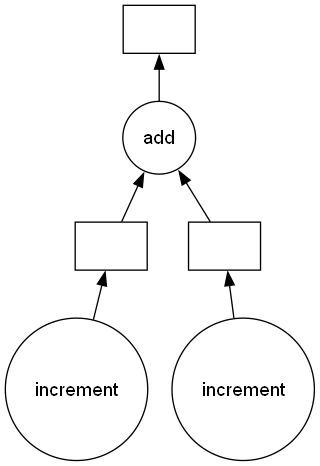

In [10]:
def increment(i):
    return i + 1

def add(x, y):
    return x + y

# функции переноса внутри отложенного объекта и цепочки
x = delayed(increment)(1)
y = delayed(increment)(2)
z = delayed(add)(x, y)

# visualize the DAG
z.visualize()

In [11]:
# show the result
z.compute()

5

Обратите внимание на то, что:

- Чтобы построить узел, в функцию передали захваченный объект, а затем передали аргументы этой функции. Можно использовать декораторы.

- Круги указывают на функцию и вычисления, а квадраты — промежуточный или конечный результат.

- Входящие стрелки представляют зависимости. Функция `increment` не имеет никаких зависимостей, а функция `add` — две. Таким образом, функция `add`  должна ждать, пока не будут вычислены объекты `x` и `y`.

- Функции без зависимостей могут вычисляться независимо, и каждой из них можно назначить `workera`.

- Используйте метод `.visualize()` на последнем узле с зависимостями.

- `Dask` не расчитывает `DAG`. Используйте метод `.compute()` на последнем узле, чтобы увидеть результат.

`2.2.2.` **Визуализировать `DAG` с более чем одним узлом и зависимостями.**

построить более сложную группу `DAG` с двумя уровнями:

- `Layer1` создается путем циклического перебора списка данных  в ​`​dask` . Этот слой объединяет ранее созданное приращение функции со значениями в списке, а затем использует встроенное суммирование функции для объединения результатов;

- `Layer2` построен циклически для каждого объекта, созданного в `Layer1`.

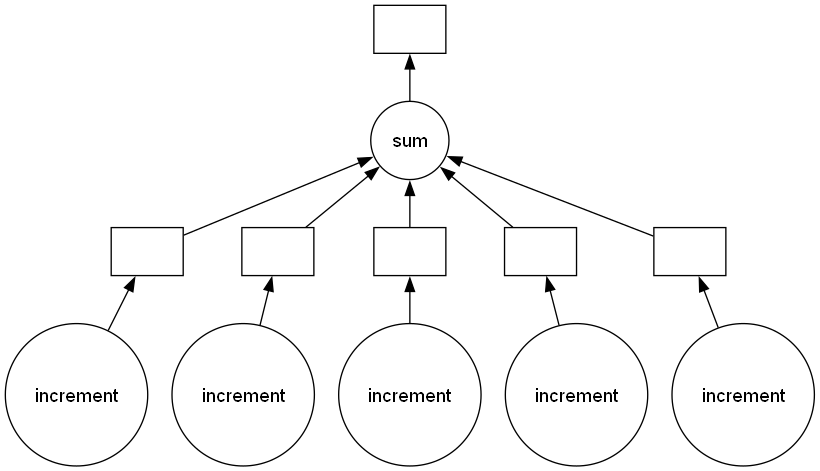

In [12]:
data = [1, 2, 3, 4, 5]

# compile first layer and visualize
layer1 = [delayed(increment)(i) for i in data]
total1 = delayed(sum)(layer1)
total1.visualize()

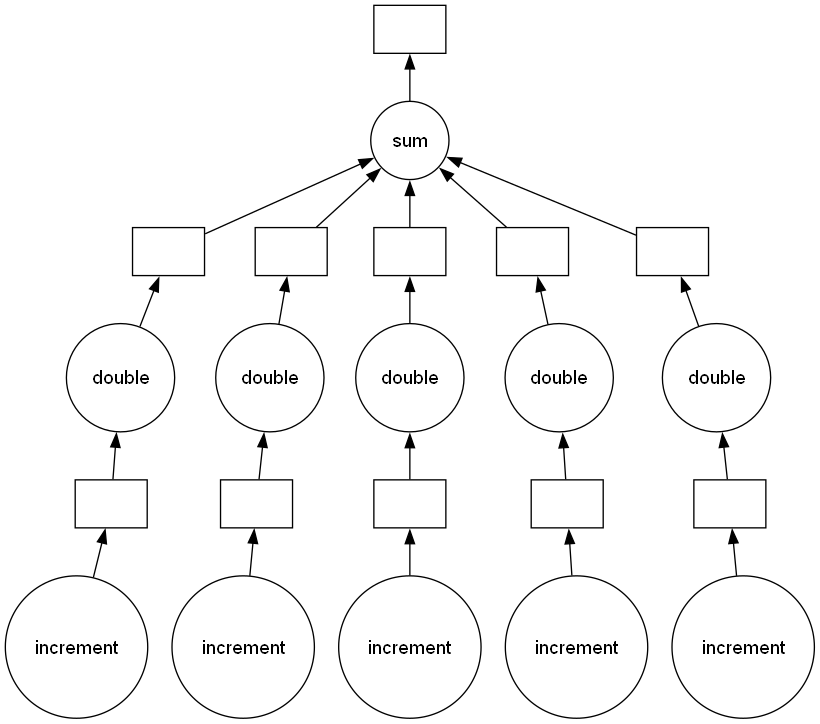

In [13]:
def double(x):
    return x * 2

# compile second layer and visualize
layer2 = [delayed(double)(j) for j in layer1]
total2 = delayed(sum)(layer2)#.persist()
total2.visualize()

In [14]:
z = total2.compute()
z

40

Обратите внимание на то, что:

- построение через использование функции,

- используем `.persist()`, и результат будет представлен на графике в виде прямоугольника.

In [15]:
# visualize DAGs built from the DataFrame
missing_count.visualize()

# Самостоятельная работа

Каталог датасетов [тут](https://disk.yandex.ru/d/fbPE3VNKYocd7g). Прямая ссылка https://disk.yandex.ru/d/fbPE3VNKYocd7g.

Выполнить пункты

`2.1.1.` - `2.1.4.`,

`2.2.1.` - `2.2.2.`,

по вариантам:

01. `Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv`.
02. `Parking_Violations_Issued_-_Fiscal_Year_2015.csv`.
03. `Parking_Violations_Issued_-_Fiscal_Year_2016.csv`.
04. `Parking_Violations_Issued_-_Fiscal_Year_2017.csv`.
05. `UK Property Price official data 1995-202304.zip`.
06. `Austin, TX House Listings.zip`.
07. `Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv`.
08. `Parking_Violations_Issued_-_Fiscal_Year_2015.csv`.
09. `Parking_Violations_Issued_-_Fiscal_Year_2016.csv`.
10. `Parking_Violations_Issued_-_Fiscal_Year_2017.csv`.
11. `UK Property Price official data 1995-202304.zip`.
12. `Austin, TX House Listings.zip`.
13. `Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv`.
14. `Parking_Violations_Issued_-_Fiscal_Year_2015.csv`.
15. `Parking_Violations_Issued_-_Fiscal_Year_2016.csv`.
16. `Parking_Violations_Issued_-_Fiscal_Year_2017.csv`.
17. `UK Property Price official data 1995-202304.zip`.
18. `Austin, TX House Listings.zip`.
19. `Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv`.
20. `Parking_Violations_Issued_-_Fiscal_Year_2015.csv`.
21. `Parking_Violations_Issued_-_Fiscal_Year_2016.csv`.
22. `Parking_Violations_Issued_-_Fiscal_Year_2017.csv`.
23. `UK Property Price official data 1995-202304.zip`.
24. `Austin, TX House Listings.zip`.
25. `Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv`.




